In [1]:
# import libraries
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
# from pmdarima import auto_arima                              # for determining ARIMA orders
from statsmodels.tsa.stattools import adfuller

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import time
from datetime import datetime

# Lines below are just to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load and shoe 1st 5 rows of data
df = pd.read_csv('../dataset/full_COA_v3.csv') #[['Time' , 'COA', 'temp']]
df.head()

,Time,COA,temp,dewPoint,humidity,windSpeed,year,quarter,month,day,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_name,hour_24,weekday_no,weekend_bool,school_vacation
0,2012-01-01 01:00:00,5986.0,13.98,0.01,0.38,3.09,2012,1,1,1,...,0,0,0,0,1,Sunday,1,6,0.0,0.0
1,2012-01-01 02:00:00,5547.0,11.98,0.99,0.47,2.06,2012,1,1,1,...,0,0,0,0,1,Sunday,2,6,0.0,0.0
2,2012-01-01 03:00:00,5233.0,11.98,0.99,0.47,2.06,2012,1,1,1,...,0,0,0,0,1,Sunday,3,6,0.0,0.0
3,2012-01-01 04:00:00,5150.0,11.98,0.01,0.44,2.06,2012,1,1,1,...,0,0,0,0,1,Sunday,4,6,0.0,0.0
4,2012-01-01 05:00:00,5235.0,11.98,0.01,0.44,3.60,2012,1,1,1,...,0,0,0,0,1,Sunday,5,6,0.0,0.0


In [3]:
df = pd.get_dummies(df , columns = ['weekday_name'] , drop_first=True)

In [4]:
# set time column as index
df_l = df.set_index('Time')

In [5]:
# set frequncy to hourly
df_l.index.freq = '1H'

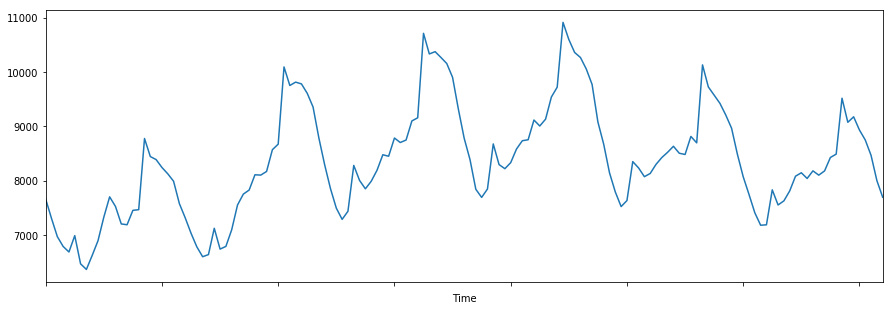

In [6]:
# plot a week worth of data
df_l['2016-01-01 01:00:00':'2016-01-07 01:00:00'].COA.plot(figsize=(15,5)).autoscale(axis='x',tight=True)

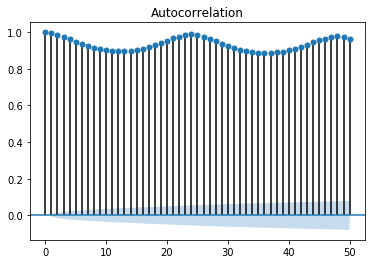

In [7]:
# plot autocorrelation
plot_acf(df_l.COA , lags=50);

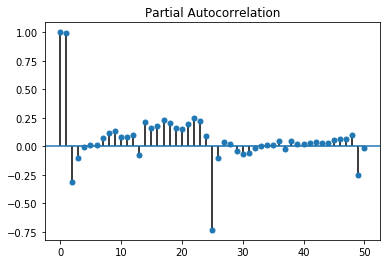

In [8]:
# plot partial autocorrelation
plot_pacf(df_l.COA , lags=50);

In [9]:
# define function for Dickey-Fuller Test 

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [10]:
# doing Dickey-Fuller Test
adf_test(df_l.COA)

Augmented Dickey-Fuller Test: 
ADF test statistic         -3.208369
p-value                     0.019505
# lags used                58.000000
# observations          52548.000000
critical value (1%)        -3.430474
critical value (5%)        -2.861595
critical value (10%)       -2.566799
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [11]:
# length to split
l_split = len(df_l['2017-12-31 00:00:00':])

In [12]:
# split by pre defined length
train = df_l.COA.iloc[:(len(df_l)-l_split)]
test = df_l.COA.iloc[(len(df_l)-l_split):]

In [13]:
# define start and end of prediction
start = len(train)
end = len(train) + len(test) - 1

In [14]:
# import statsmodels.api as sm
# import warnings
# import itertools
# # Define the d and q parameters to take any value between 0 and 1
# q = range(0, 5)
# d = range(0, 2)

# # Define the p parameters to take any value between 0 and 3
# p = range(0, 5)

# # Generate all different combinations of p, q and q triplets
# pdq = list(itertools.product(p, d, q))

# # Generate all different combinations of seasonal p, q and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

# warnings.filterwarnings("ignore") # specify to ignore warning messages
# i = 0
# AIC = []
# SARIMAX_model = []
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             i+=1
#             print('The iteration',i)
#             print('length of pdq',len(pdq))
#             print('length of seasonalpdq',len(seasonal_pdq))
#             mod = sm.tsa.statespace.SARIMAX(train,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)

#             results = mod.fit()

#             print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
#             AIC.append(results.aic)
#             SARIMAX_model.append([param, param_seasonal])
#         except:
#             continue

# print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))


In [15]:
# model = sm.tsa.statespace.SARIMAX(train,
#                                 order=SARIMAX_model[AIC.index(min(AIC))][0],
#                             seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False).fit()


In [16]:
# define exogenous variables 
exog = df_l.drop(columns=['COA'])

In [17]:
# split train and test for exogenous variables
exog_to_train = exog.iloc[:(len(df_l)-l_split)]
exog_to_test = exog.iloc[(len(df_l)-l_split):]

In [18]:
# order=(2, 0, 2) seasonal_order=(1, 1, 1, 24)

In [19]:
# grid search to find optimal parameters
# stepwise_model = auto_arima(train,
#                            m=24,
# #                            start_P=0,D=1,
#                             seasonal=True,
#                             exogenous=exog_to_train,
#                             trace=True,
#                            error_action='ignore',  
#                            suppress_warnings=True, 
#                            stepwise=True)
# print(stepwise_model.aic())

In [20]:
# use optimal parameters found
model = SARIMAX(train,
                                order=(2, 0, 2),
                            seasonal_order=(1, 1, 1, 24),
#                             exogenous=exog_to_train,
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()

In [26]:
# make prediction
predictions = model.predict(start=start , end=end ).rename('SARIMA(2, 0, 2)(1, 1, 1, 24) Predictions')

In [27]:
# change index to date time object
test.index = pd.to_datetime(test.index)

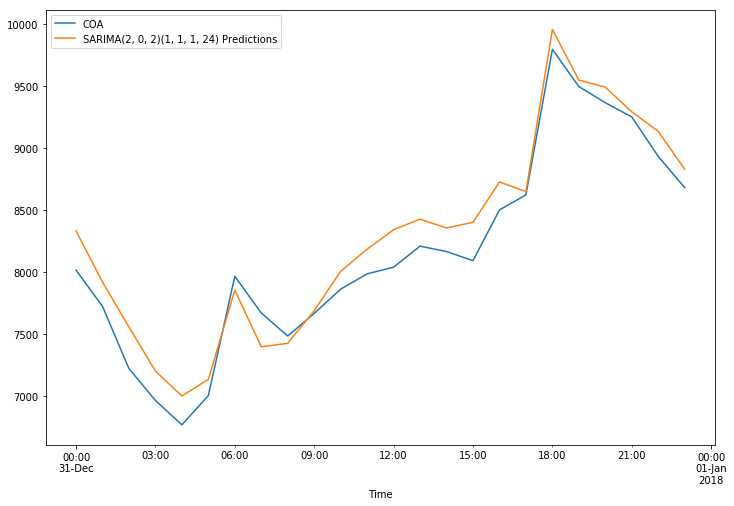

In [28]:
# plot predict vs test
test.plot(legend=True, figsize=(12,8))
predictions.plot(legend=True)

In [29]:
# calculate rmse
rmse(test.values,predictions.values)

200.2841957312197

In [30]:
# calculate r2 score
r2_score(test.values,predictions.values)

0.9368681504485041